In [1]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d,lib.cnmem=0"%(random.randint(0,3))
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras
from keras.models import Model
from IPython import display

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpwtfdvd/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpwtfdvd/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)
Using Theano backend.


In [2]:
np.set_printoptions(threshold='nan')
img_rows, img_cols = 100, 100

# the data, shuffled and split between train and test sets

# (X_train, y_train), (X_test, y_test) = mnist.load_data()

# X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
# X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train = X_train[0:320]/255
# X_test  = X_train[0:320]/255
import scipy.io as sio
#image = sio.loadmat('linescircle.mat')
#data1=np.abs(image['lines_final'])
WB=sio.loadmat('WB_test100.mat')['WB_test100']
data1=WB[0:100]
X_train=data1/1.
X_test=data1/1.
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

print np.min(X_train), np.max(X_train)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
('X_train shape:', (100L, 1L, 100L, 100L))
(100L, 'train samples')
(100L, 'test samples')


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import scipy.io as sio

batch_size = 1
original_dim = 100*100
latent_dim = 30
nb_epoch = 100

x = Input(shape=(1, 100, 100))
#h = Flatten()(x)
#x = Input(batch_shape=(batch_size, original_dim))
#h = Reshape((1,28,28))(x)
encode_h1=Convolution2D(24, 6, 6, activation='relu', border_mode='same')
encode_h2=MaxPooling2D((2, 2), border_mode='same')
encode_h3=Convolution2D(40, 9, 9, activation='relu', border_mode='same')
encode_h4=MaxPooling2D((2, 2), border_mode='same')
encode_h5= Convolution2D(144, 9, 9, activation='relu', border_mode='same')
encode_h6=MaxPooling2D((2, 2), border_mode='same')
# encode_h6=Flatten()
# encode_h7=Dense(500,activation='relu')

h = encode_h1(x)
h = encode_h2(h)
h = encode_h3(h)
h = encode_h4(h)
h = encode_h5(h)
h = encode_h6(h)
h = encode_h7(h)

# h = Flatten()(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
encoder=Model(x,z_mean)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later

decoder_h0 = Dense(500, activation='relu')
decoder_h1 = Dense(144*25*25, activation='relu')
decoder_h2 = Reshape((144,25,25))
decoder_h3 = Convolution2D(144, 9, 9, activation='relu', border_mode='same')
decoder_h4 = UpSampling2D((2, 2))
decoder_h5 = Convolution2D(40, 9, 9, activation='relu', border_mode='same')
decoder_h6 = UpSampling2D((2, 2))
decoder_h7 = Convolution2D(24, 6, 6, activation='relu',border_mode='same')
# decoder_h8 = UpSampling2D((2, 2))
decoder_h9 = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')

#g_input = Input(shape=[2])
H = decoder_h0(z)
H = decoder_h1(H)
H = decoder_h2(H)
H = decoder_h3(H)
H = decoder_h4(H)
H = decoder_h5(H)
H = decoder_h6(H)
H = decoder_h7(H)
# H = decoder_h8(H)
g_V = decoder_h9(H)

#generator = Model(z, g_V)

def vae_loss(x, g_V):
    xent_loss = K.mean(objectives.binary_crossentropy(x, g_V))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, g_V)
#keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# vae.fit(X_train, X_train,
#         shuffle=True,
#         nb_epoch=nb_epoch,
#         batch_size=batch_size,
#         validation_data=(X_test, X_test))

In [5]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 100, 100)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 24, 100, 100)  888         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 24, 50, 50)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 40, 50, 50)    77800       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [6]:
vae.fit(X_train, X_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(X_test, X_test))

Train on 100 samples, validate on 100 samples
Epoch 1/100
100/100 [==============================] - 68s - loss: nan - val_loss: nan
Epoch 2/100
  5/100 [>.............................] - ETA: 53s - loss: nan

KeyboardInterrupt: 

In [6]:
vae.fit(X_train, X_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(X_test, X_test))

Train on 100 samples, validate on 100 samples
Epoch 1/500
100/100 [==============================] - 0s - loss: 67.6665 - val_loss: 70.9731
Epoch 2/500
100/100 [==============================] - 0s - loss: 83.9549 - val_loss: 76.9304
Epoch 3/500
100/100 [==============================] - 0s - loss: 75.1144 - val_loss: 70.8627
Epoch 4/500
100/100 [==============================] - 0s - loss: 67.8689 - val_loss: 66.2907
Epoch 5/500
100/100 [==============================] - 0s - loss: 65.9074 - val_loss: 64.9124
Epoch 6/500
100/100 [==============================] - 0s - loss: 67.2578 - val_loss: 92.6595
Epoch 7/500
100/100 [==============================] - 0s - loss: 90.4970 - val_loss: 85.1594
Epoch 8/500
100/100 [==============================] - 0s - loss: 73.2743 - val_loss: 66.6163
Epoch 9/500
100/100 [==============================] - 0s - loss: 67.8806 - val_loss: 65.5157
Epoch 10/500
100/100 [==============================] - 0s - loss: 65.0357 - val_loss: 70.9352
Epoch 11/500


ValueError: I/O operation on closed file

In [29]:
keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08)
vae.fit(X_train, X_train,
        shuffle=True,
        nb_epoch=500,
        batch_size=batch_size,
        validation_data=(X_test, X_test))

Train on 100 samples, validate on 100 samples
Epoch 1/500
100/100 [==============================] - 0s - loss: 102.3421 - val_loss: 102.9997
Epoch 2/500
100/100 [==============================] - 0s - loss: 102.2081 - val_loss: 103.7001
Epoch 3/500
100/100 [==============================] - 0s - loss: 102.2138 - val_loss: 97.4601
Epoch 4/500
100/100 [==============================] - 0s - loss: 96.7950 - val_loss: 103.8979
Epoch 5/500
100/100 [==============================] - 0s - loss: 97.4585 - val_loss: 98.9753
Epoch 6/500
100/100 [==============================] - 0s - loss: 97.7132 - val_loss: 96.3137
Epoch 7/500
100/100 [==============================] - 0s - loss: 91.0319 - val_loss: 87.6033
Epoch 8/500
100/100 [==============================] - 0s - loss: 87.2821 - val_loss: 96.6289
Epoch 9/500
100/100 [==============================] - 0s - loss: 94.3938 - val_loss: 106.3478
Epoch 10/500
100/100 [==============================] - 0s - loss: 102.5841 - val_loss: 115.2608
Epoc

In [7]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded  = decoder_h1(decoder_input)
_h_decoded  = decoder_h2(_h_decoded)
_h_decoded  = decoder_h3(_h_decoded)
_h_decoded  = decoder_h4(_h_decoded)
_h_decoded  = decoder_h5(_h_decoded)
_h_decoded  = decoder_h6(_h_decoded)
_h_decoded  = decoder_h7(_h_decoded)
_h_decoded  = decoder_h8(_h_decoded)
_x_decoded_mean = decoder_h9(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

c:\anaconda\lib\site-packages\matplotlib\axes\_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


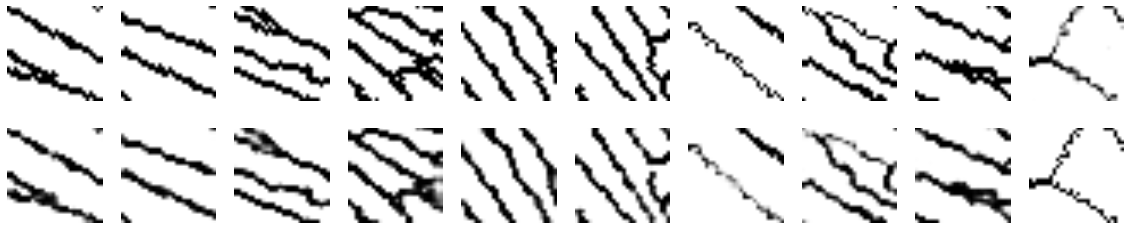

In [8]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = generator.predict(encoded_imgs)
plt.figure(figsize=(20, 4))
n=10
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(10, 10))
plt.show()

In [62]:
test1=encoded_imgs[4]
test1

array([ 3.93599486, -2.40307689,  0.73116934, -2.03931475], dtype=float32)

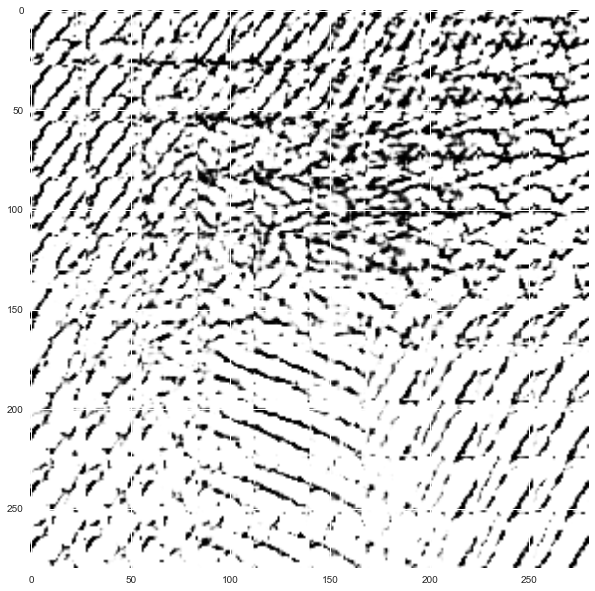

In [9]:
# import seaborn.apionly as sns
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)
grid_z = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        #for k, zi in enumerate(grid_z):
        z_sample = np.array([[0, 0, xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [10]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = generator.predict(encoded_imgs)

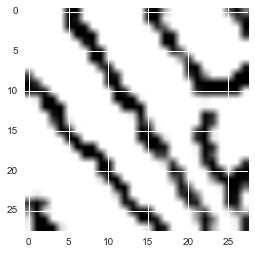

In [17]:
plt.imshow(decoded_imgs[6][0],'gray')

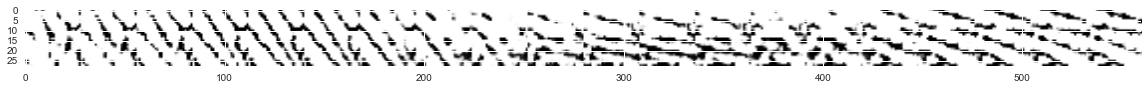

In [16]:
test1=encoded_imgs[6]
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((28, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)
grid_z = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_y):
    #for j, xi in enumerate(grid_x):
        #for k, zi in enumerate(grid_z):
        test1[0]=yi
        z_sample=test1.reshape([1,4])
#         z_sample = np.array([[0, 0, 0, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[0: 28,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure,'gray')
plt.show()

In [81]:
figure.shape

(28L, 840L)

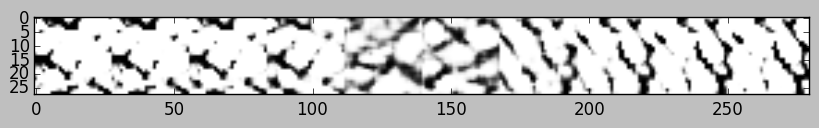

In [23]:
#import seaborn.apionly as sns
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((28, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)
grid_z = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_y):
    #for j, xi in enumerate(grid_x):
        #for k, zi in enumerate(grid_z):
        z_sample = np.array([[0, 0, yi, 0]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[0: 28,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

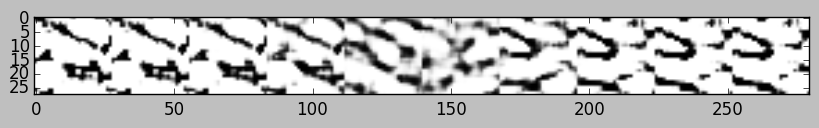

In [24]:
#import seaborn.apionly as sns
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((28, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)
grid_z = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_y):
    #for j, xi in enumerate(grid_x):
        #for k, zi in enumerate(grid_z):
        z_sample = np.array([[0, yi, 0, 0]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[0: 28,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

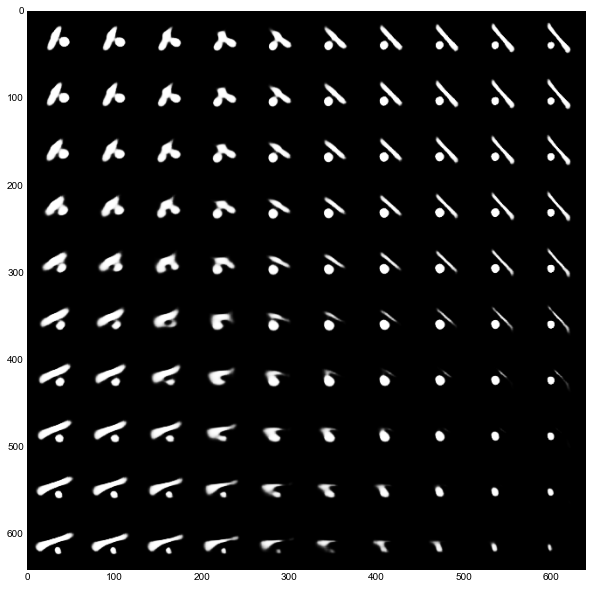

In [239]:
import seaborn
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        #for k, zi in enumerate(grid_z):
        z_sample = np.array([[2.58674383, -0.10538019,  xi, yi,  1.31130505,
        -0.48292583,  0.83315235]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

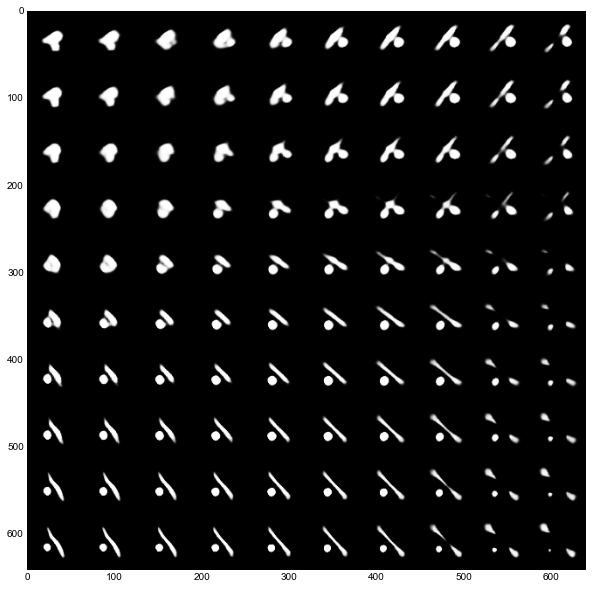

In [247]:
import seaborn
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        #for k, zi in enumerate(grid_z):
        z_sample = np.array([[2.58674383, xi,  yi, -1.70217288,  1.31130505,
        -0.48292583,  0.83315235]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

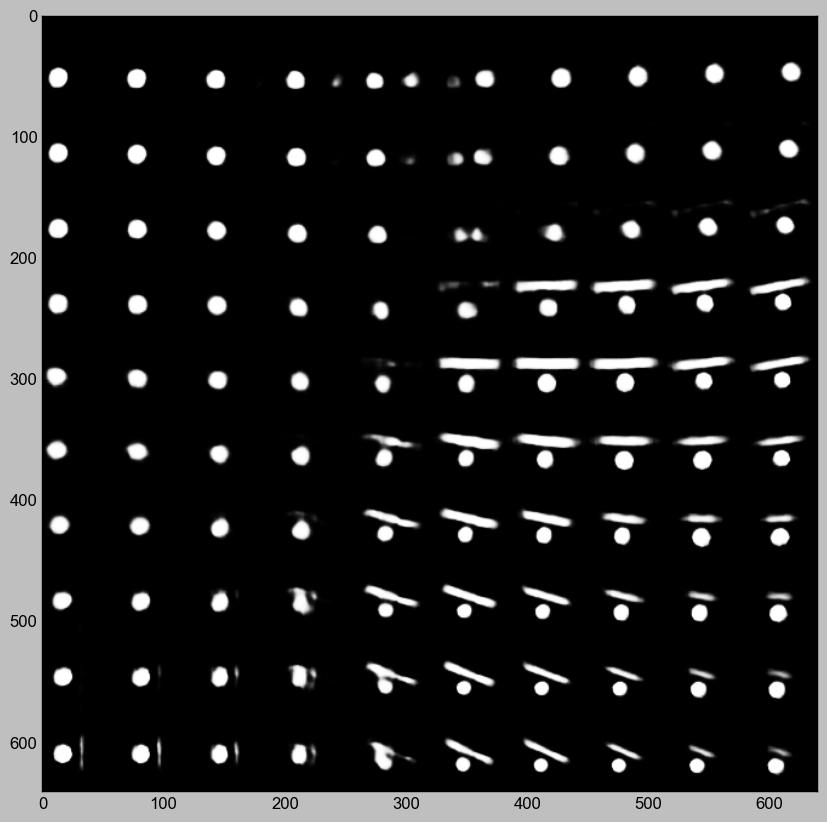

In [210]:
for i, yi in enumerate(grid_y):
    for k, zi in enumerate(grid_z):
        #for k, zi in enumerate(grid_z):
        z_sample = np.array([[2, yi, zi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               k * digit_size: (k + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

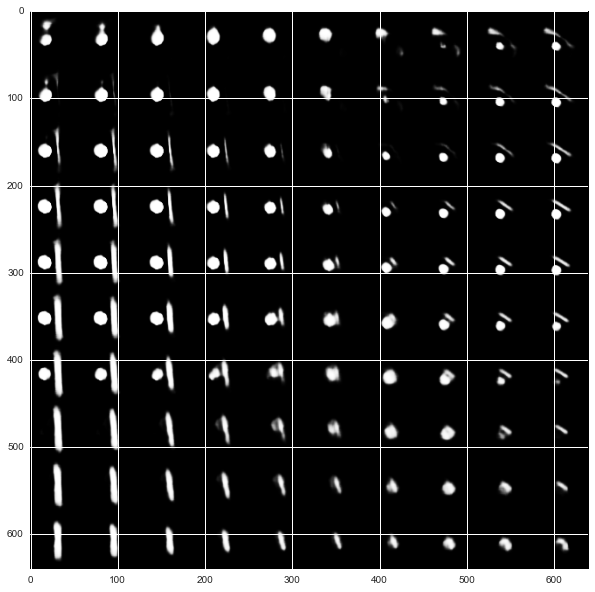

In [21]:
for i, xi in enumerate(grid_x):
    for k, zi in enumerate(grid_z):
        #for k, zi in enumerate(grid_z):
        z_sample = np.array([[xi, 15, zi]])*0.1
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               k * digit_size: (k + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

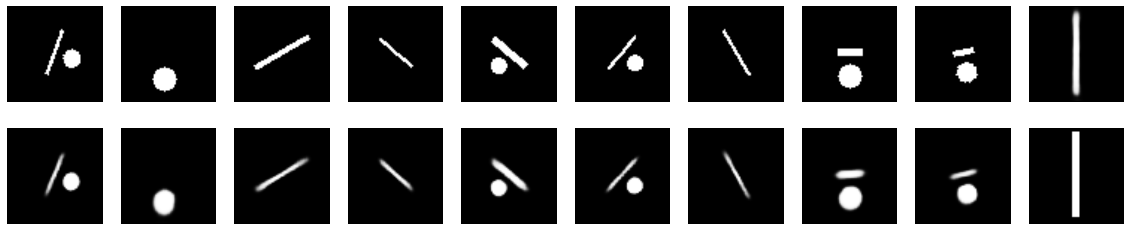

In [214]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = generator.predict(encoded_imgs)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(10, 10))
plt.show()

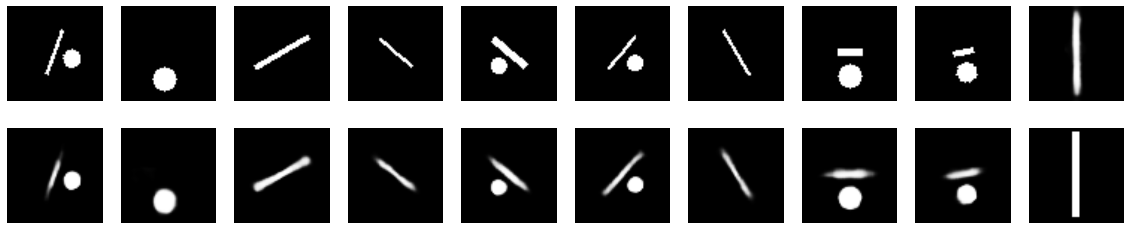

In [204]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = generator.predict(encoded_imgs)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(10, 10))
plt.show()

In [64]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

('W shape : ', (24L, 3L, 3L))


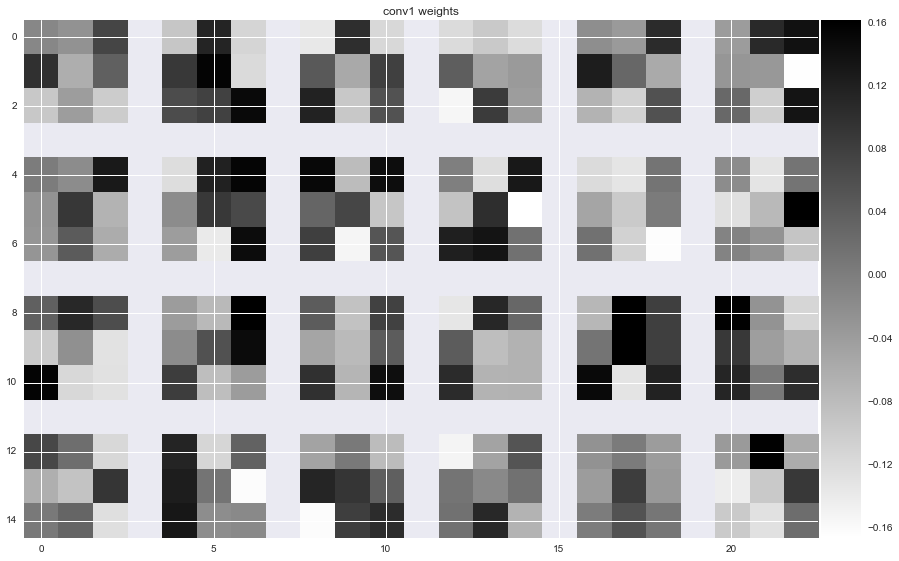

In [68]:
# Visualize weights
import pylab as pl
import matplotlib.cm as cm
W = vae.layers[1].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 4, 6), cmap=cm.binary)

In [177]:
from theano.tensor.nnet import conv2d
W1_temp = vae.layers[1].W.get_value(borrow=True)
W1_temp = np.transpose(W1_temp,(1,0,2,3))
W2_temp = vae.layers[3].W.get_value(borrow=True)

In [178]:
print W1_temp.shape
print W2_temp.shape

(1L, 24L, 3L, 3L)
(40L, 24L, 3L, 3L)


In [179]:
import cv2
data2=np.zeros((40,24,6,6))
for i in range(40):
    for j in range(24):
        XXX=W2_temp[i,j,:,:].reshape(3,3)
        temp=cv2.resize(XXX,(6,6))
        #temp[temp>=0.5]=1
        #temp[temp<=0.5]=0
        data2[i,j,:,:]=temp
print data2.shape
W2_temp=data2

(40L, 24L, 6L, 6L)


In [185]:
import theano
W1 = T.dtensor4('W1')
W2 = T.dtensor4('W2')
W2W1 = conv2d(input=W2, filters=W1,border_mode='full')
f = theano.function([W1,W2],W2W1)

W2_real=f(W1_temp,W2_temp)
W2_real=np.transpose(W2_real,(1,0,2,3))
W2_real.shape

(1L, 40L, 8L, 8L)

In [187]:
W3_temp.shape

(144L, 40L, 3L, 3L)

In [194]:
W3_temp = vae.layers[5].W.get_value(borrow=True)
print 'W3 w/o conv2d=', W3_temp.shape

data2=np.zeros((144,40,18,18))
for i in range(144):
    for j in range(40):
        XXX=W3_temp[i,j,:,:].reshape(3,3)
        temp=cv2.resize(XXX,(18,18))
        #temp[temp>=0.5]=1
        #temp[temp<=0.5]=0
        data2[i,j,:,:]=temp
print 'W3_temp pooling back=', data2.shape
W3_temp=data2

W2 = T.dtensor4('W2')
W3 = T.dtensor4('W3')
W3W2 = conv2d(input=W2, filters=W3, border_mode='full')
f = theano.function([W2,W3],W3W2)

W3_real=f(W2_real,W3_temp)
W3_real=np.transpose(W3_real,(1,0,2,3))
print 'W3_real shape = ',W3_real.shape

W3 w/o conv2d= (144L, 40L, 3L, 3L)
W3_temp pooling back= (144L, 40L, 18L, 18L)
W3_real shape =  (144L, 1L, 25L, 25L)


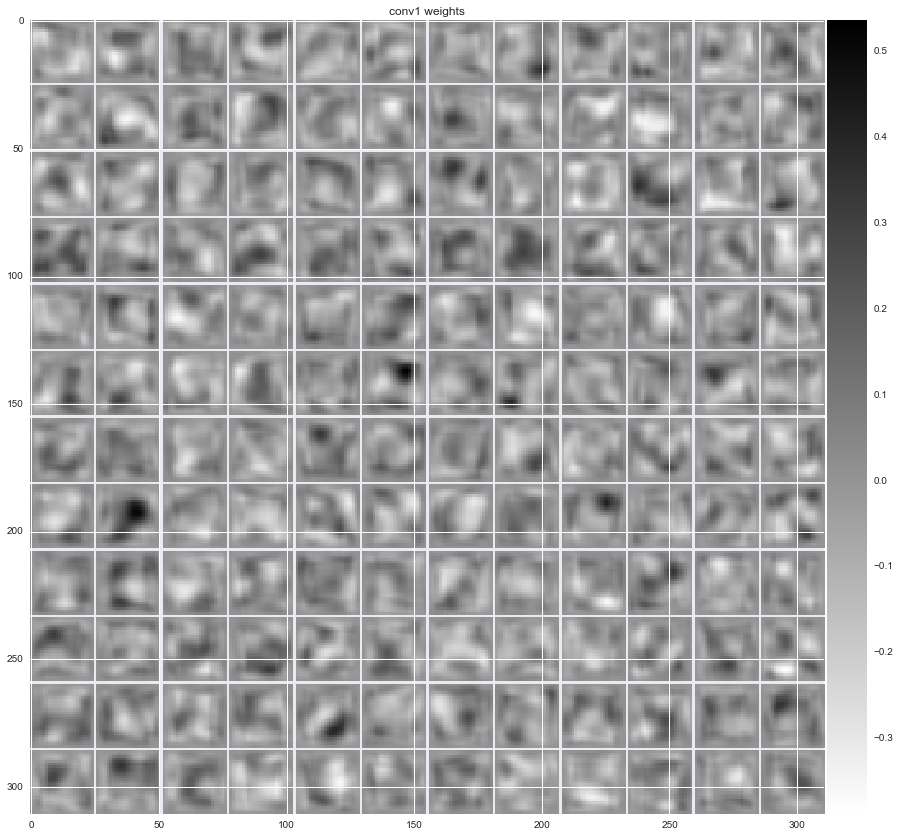

In [196]:
W3_real = np.squeeze(W3_real)
pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W3_real, 12, 12), cmap=cm.binary)